# 电子商务数值数据与文本分析案例
_作者：张伟 2022-12-29_
***
# 目录

* [1.简介](#introduction)
    *  [1.1 统计性描述](##statiscs)
    *  [1.2 数据预处理](##preprocess)
* [2.自定义变量分布](#Univariable)
* [3.多变量分布](#MultiVariable)
* [4.因子相关性分析](#MultiVariable_analysis)
* [5.文本处理](#texthandling)
    *  [5.1 文本预处理](##text_preprocess)
    *  [5.2 情感分析](##sentiment_analysis)
    *  [5.3 词分布与词云](##wordcloud)
* [6.ngrams](#ngrams)
* [7.朴素贝叶斯](#bayes)
* [8.参考文献](#reference)

# 1. 简介 <a id="Introduction"></a>

本文将通过传统统计学和自然语言处理技术来探索一个数据脱敏的女装电子商务平台的客户评论的趋势，并提取可操作的计划来改善其在线电子商务。该数据是22641行和10列属性的集合。每一行都包括一个书面评论以及额外的客户信息。这个分析将集中在使用自然语言技术来寻找客户书面想法的大趋势。数据集中的独特字数共计9810个。

本文的目标是要了解顾客对他们购买的东西的偏好分类，即通俗意义上的”喜欢“与”不喜欢“。

## 1.1 统计性描述<a id="statiscs"></a>

In [1]:
import numpy as np 
import pandas as pd 
import seaborn as sns
import torch
import nltk
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
import warnings
import time
warnings.filterwarnings('ignore')
df = pd.read_csv("/kaggle/input/womens-ecommerce-clothing-reviews/Womens Clothing E-Commerce Reviews.csv")

In [2]:
df.describe().T.drop("count",axis=1)

,mean,std,min,25%,50%,75%,max
Unnamed: 0,11742.500000,6779.968547,0.0,5871.25,11742.5,17613.75,23485.0
Clothing ID,918.118709,203.298980,0.0,861.00,936.0,1078.00,1205.0
Age,43.198544,12.279544,18.0,34.00,41.0,52.00,99.0
Rating,4.196032,1.110031,1.0,4.00,5.0,5.00,5.0
Recommended IND,0.822362,0.382216,0.0,1.00,1.0,1.00,1.0
Positive Feedback Count,2.535936,5.702202,0.0,0.00,1.0,3.00,122.0


In [3]:
print(df.isnull().sum())
print(df.columns)
print(df.shape)

Unnamed: 0                    0
Clothing ID                   0
Age                           0
Title                      3810
Review Text                 845
Rating                        0
Recommended IND               0
Positive Feedback Count       0
Division Name                14
Department Name              14
Class Name                   14
dtype: int64
Index(['Unnamed: 0', 'Clothing ID', 'Age', 'Title', 'Review Text', 'Rating',
       'Recommended IND', 'Positive Feedback Count', 'Division Name',
       'Department Name', 'Class Name'],
      dtype='object')
(23486, 11)


在23486条数据中缺损值分别为：Title 3810条，Review Text 845条，Review Text、Class Name 、Department Name各14条，

<AxesSubplot:xlabel='Age', ylabel='Count'>

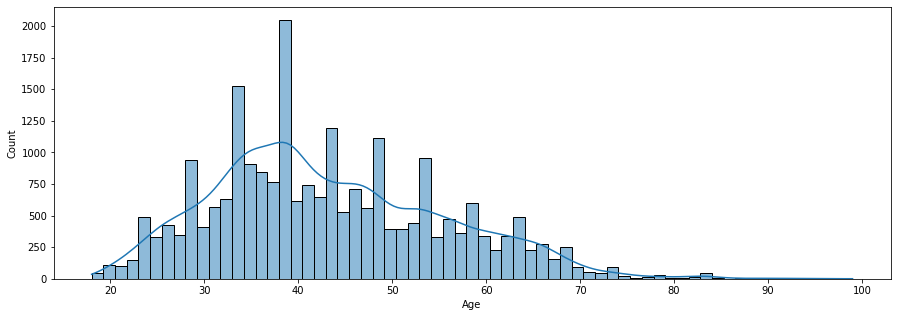

In [4]:
plt.figure(figsize = (15,5))
sns.histplot(data=df['Age'], kde=True)

<AxesSubplot:xlabel='Class Name', ylabel='Count'>

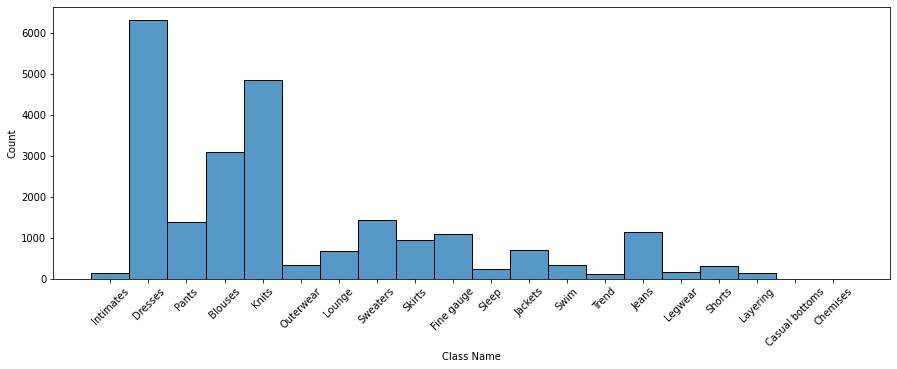

In [5]:
plt.figure(figsize = (15,5))
plt.xticks(rotation=45)
sns.histplot(data=df['Class Name'])

<AxesSubplot:xlabel='Division Name', ylabel='Count'>

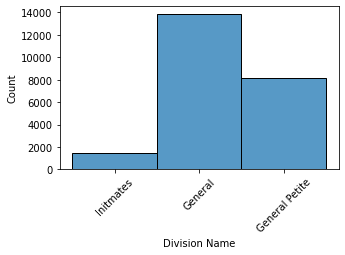

In [6]:
plt.figure(figsize = (5,3))
plt.xticks(rotation=45)
sns.histplot(data=df['Division Name'])

<AxesSubplot:xlabel='Department Name', ylabel='Count'>

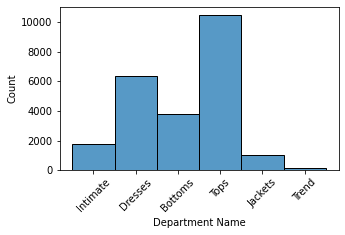

In [7]:
plt.figure(figsize = (5,3))
plt.xticks(rotation=45)
sns.histplot(data=df['Department Name'])

([<matplotlib.patches.Wedge at 0x7f4200dbbb10>,
 [Text(-0.9331092333575896, 0.5825007799332219, 'Recommended'),
  Text(0.9331092060887587, -0.5825008236152175, 'Not Recommended')],
 [Text(-0.5089686727405033, 0.3177276981453937, '82%'),
  Text(0.5089686578665956, -0.31772772197193677, '18%')])

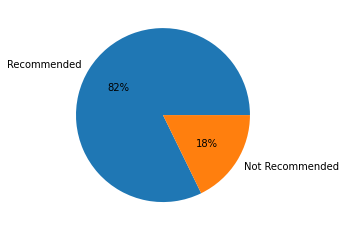

In [8]:
r1 = df[df['Recommended IND']==1].shape[0]
r0 = df[df['Recommended IND']==0].shape[0]
data = [r1,r0]
labels = ['Recommended','Not Recommended']
plt.pie(data, labels=labels, autopct = '%0.0f%%')

看出该电商的主要消费者的为中年40岁左右的中年女性。

## 1.2 数据预处理<a id="preprocess"></a>


In [9]:
# 删除所有含有缺损值数据
df.dropna(how='any',inplace=True)
# 评论的单词数
word_list = df['Review Text'].str.split()
df["Word Count"] = word_list.apply(len)
# 评论的文本长度
df["Character Count"] = df['Review Text'].apply(len)
# 评分大于等于3的为1，小于3的为0
df["Label"] = 0
df.loc[df.Rating >= 3,["Label"]] = 1
df.describe().T.drop("count",axis=1)

,mean,std,min,25%,50%,75%,max
Unnamed: 0,11755.260655,6772.063092,2.0,5888.25,11749.5,17624.75,23485.0
Clothing ID,921.297274,200.227528,1.0,861.00,936.0,1078.00,1205.0
Age,43.260808,12.258122,18.0,34.00,41.0,52.00,99.0
Rating,4.183145,1.112224,1.0,4.00,5.0,5.00,5.0
Recommended IND,0.818177,0.385708,0.0,1.00,1.0,1.00,1.0
Positive Feedback Count,2.652477,5.834285,0.0,0.00,1.0,3.00,122.0
Word Count,62.115146,28.200497,2.0,38.00,62.0,90.00,115.0
Character Count,318.444817,142.268450,9.0,199.00,315.0,475.00,508.0
Label,0.895687,0.305674,0.0,1.00,1.0,1.00,1.0


# 2. 自定义变量分布<a id="Univariable"></a>

<AxesSubplot:xlabel='Word Count', ylabel='Count'>

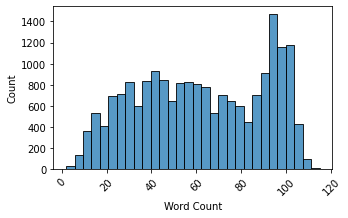

In [10]:
plt.figure(figsize = (5,3))
plt.xticks(rotation=45)
sns.histplot(data=df['Word Count'])

<AxesSubplot:xlabel='Character Count', ylabel='Count'>

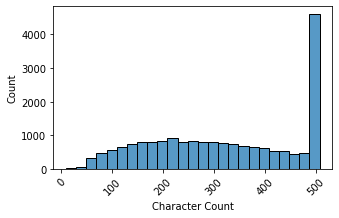

In [11]:
plt.figure(figsize = (5,3))
plt.xticks(rotation=45)
sns.histplot(data=df['Character Count'])

# 3. 多变量分布<a id="MultiVariable"></a>
在这一节中，利用热图来可视化百分比发生率透视表。请注意，大量使用了将频率转换为百分比的技术来规范变量类之间的比例。这种技术是非常有成效的，因为百分比所依据的关系可以通过集合、索引和列来探索，每一个都提供了它自己独特的见解。




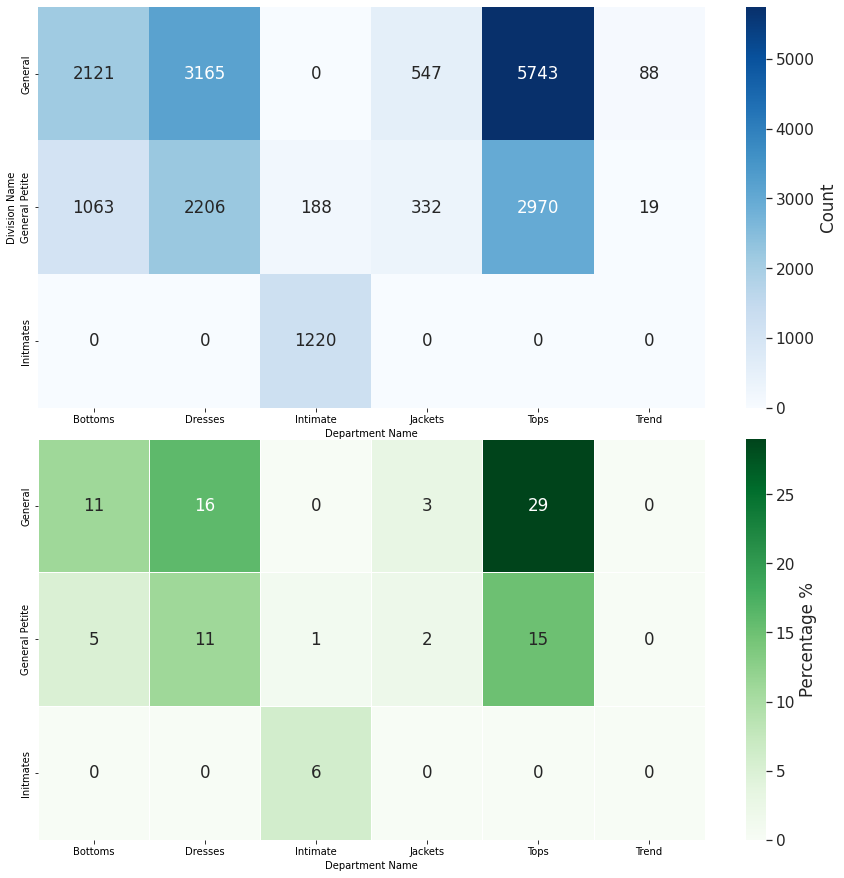

In [12]:
f, ax = plt.subplots(2,1,figsize=(12, 12), sharey=True)
# 通过交叉表来统计分组频率
tab_1 = pd.crosstab(df['Division Name'], df["Department Name"])
sns.set(font_scale=1.4)
sns.heatmap(tab_1,
            annot=True, 
            ax = ax[0],
            fmt='g', 
            cmap="Blues",
            cbar_kws={'label': 'Count'})
# 对于交叉表标准化后，乘以100，基于统计数目转换为概率分布
tab_2 = pd.crosstab(df['Division Name'], df["Department Name"], normalize=True).mul(100).round(0)

sns.heatmap(tab_2,
            annot=True, 
            linewidths=.5, 
            ax=ax[1],
            fmt='g',
            cmap="Greens",
            cbar_kws={'label': 'Percentage %'})
ax[1].set_ylabel('')
plt.tight_layout(pad=0)

通过交叉表可以看出“普通上装”是卖的最好的服饰，其次是“普通连衣裙”，“小版上装”

# 4. 因子相关性分析<a id="MultiVariable_analysis"></a>

Text(0.5, 1.0, 'Factors Ranker')

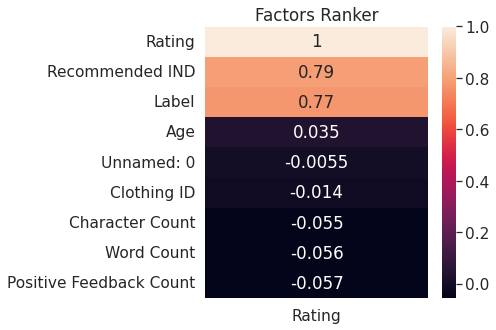

In [13]:
plt.figure(figsize = (5,5))
sns.heatmap(df.corr()[['Rating']].sort_values(by='Rating', ascending=False), annot = True)
plt.title('Factors Ranker')


# 5. 文本处理<a id="texthandling"></a>
接下来我们进行文本分析，对于一家电商而言，文本内容主要是来自评论区的标题与内容。

In [14]:
pd.set_option('max_colwidth', 500)
# 在原始数据中随机抽取3个样本
df[["Title","Review Text", "Rating",'Label']].sample(3)

,Title,Review Text,Rating,Label
10063,Simple yet sexy and feminine,"I bought this today in navy and loved it the second i put it on. it feels great on, is well made and flattering! you can wear it anywhere and look pulled together. much cuter in real life too. it does run a little small. id go up a size if you're getting the white so it won't cling too much.",5,1
1791,Fun & flirty take on preppy look,"I bought the grey and white plaid shirt in a large. i'm 165, 36d and the top closes without gaping - even when i push my shoulders back. it's kind of sheer, so will wear a cami underneath. the waist nips in right where it should - giving a trim silhouette. adorable and fun top, without being cutesy. love tylho tops!",5,1
23154,Odd back pockets,"I have several pairs of coh and love them all. when i saw these go on sale in my size i quickly purchased them. however, when i tried them on at home and looked in the mirror, i was pretty shocked that the back pockets were extremely long. meaning, they go well below your butt cheeks (like 3""# which means they look like they are sitting too low on your body-and they aren't they are actually i little higher waisted than most coh! \r\n\r\ni thought perhaps it was my perception that day, so i w...",3,1


## 5.1 文本预处理<a id="text_preprocess"></a>
本文使用Transformer库对文本数据进行处理，使用的预训练单词表为bert-base-cased。

In [15]:
import transformers as tfs
from transformers import AutoTokenizer
tokenizer = AutoTokenizer.from_pretrained('bert-base-cased')

Downloading:   0%|          | 0.00/29.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/570 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/208k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/426k [00:00<?, ?B/s]

In [16]:
# 由于NLP算法的计算较为耗时，我们仅仅取其中的3000条数据作为训练集
train_set = df[:3000]
print(train_set['Label'].value_counts())
model_class, tokenizer_class, pretrained_weights = (tfs.BertModel, tfs.BertTokenizer, 'bert-base-uncased')
tokenizer = tokenizer_class.from_pretrained(pretrained_weights)
model = model_class.from_pretrained(pretrained_weights)
train_tokenized = train_set['Review Text'].apply((lambda x: tokenizer.encode(x, add_special_tokens=True)))


1    2681
0     319
Name: Label, dtype: int64


Downloading:   0%|          | 0.00/226k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/28.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/570 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/420M [00:00<?, ?B/s]

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.bias', 'cls.seq_relationship.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


## 5.2 情感分析<a id="sentiment_analysis"></a>

In [17]:
from nltk.sentiment.vader import SentimentIntensityAnalyzer

SIA = SentimentIntensityAnalyzer()
df["Review Text"]= df["Review Text"].astype(str)

# Applying Model, Variable Creation
df['Polarity Score']=df["Review Text"].apply(lambda x:SIA.polarity_scores(x)['compound'])
df['Neutral Score']=df["Review Text"].apply(lambda x:SIA.polarity_scores(x)['neu'])
df['Negative Score']=df["Review Text"].apply(lambda x:SIA.polarity_scores(x)['neg'])
df['Positive Score']=df["Review Text"].apply(lambda x:SIA.polarity_scores(x)['pos'])

# Converting 0 to 1 Decimal Score to a Categorical Variable
df['Sentiment']=''
df.loc[df['Polarity Score']>0,'Sentiment']='Positive'
df.loc[df['Polarity Score']==0,'Sentiment']='Neutral'
df.loc[df['Polarity Score']<0,'Sentiment']='Negative'

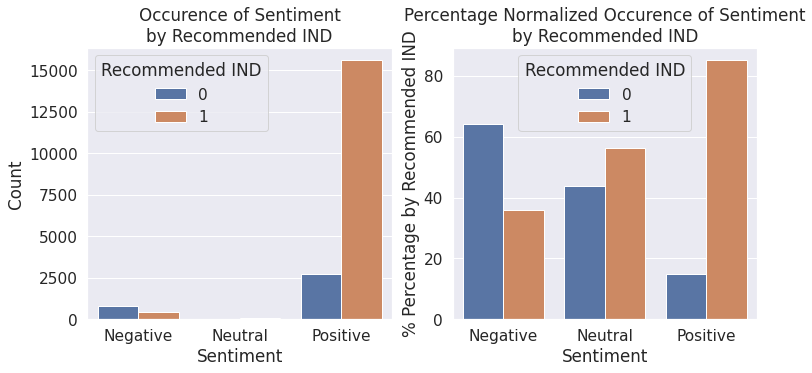

In [18]:
def percentstandardize_barplot(x,y,hue, data, ax=None, order= None):
    """
    Standardize by percentage the data using pandas functions, then plot using Seaborn.
    Function arguments are and extention of Seaborns'.
    """
    sns.barplot(x= x, y=y, hue=hue, ax=ax, order=order,
    data=(data[[x, hue]]
     .reset_index(drop=True)
     .groupby([x])[hue]
     .value_counts(normalize=True)
     .rename('Percentage').mul(100)
     .reset_index()
     .sort_values(hue)))
    plt.title("Percentage Frequency of {} by {}".format(hue,x))
    plt.ylabel("Percentage %")
huevar = "Recommended IND"
xvar = "Sentiment"
f, axes = plt.subplots(1,2,figsize=(12,5))
sns.countplot(x=xvar, hue=huevar,data=df, ax=axes[0], order=["Negative","Neutral","Positive"])
axes[0].set_title("Occurence of {}\nby {}".format(xvar, huevar))
axes[0].set_ylabel("Count")
percentstandardize_barplot(x=xvar,y="Percentage", hue=huevar,data=df, ax=axes[1])
axes[1].set_title("Percentage Normalized Occurence of {}\nby {}".format(xvar, huevar))
axes[1].set_ylabel("% Percentage by {}".format(huevar))
plt.show()


## 5.3 词分布与词云<a id="wordcloud"></a>


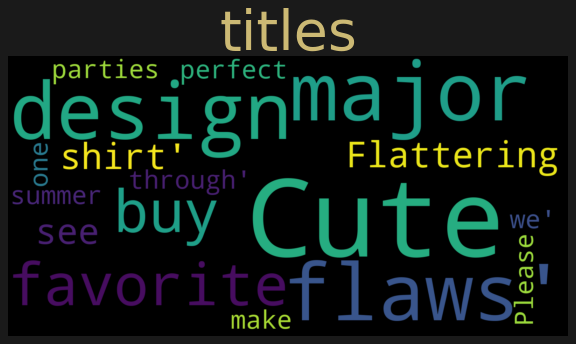

In [19]:
# 导入词云和停用词，
from wordcloud import WordCloud, STOPWORDS
# 所谓停用词是指我、你、将这些日常口语词汇
stopwords = set(STOPWORDS)
# 同时我们自定义过滤词汇，比如原数据中的字段名称：
fieldnames = list(df['Class Name'].unique())
customerwords = ["dress", "petite","made","will"]
fieldnames.extend(customerwords)
stopwords.update([x.lower() for x in fieldnames])
size = (10,7)

def cloud(text, title, stopwords=stopwords, size=size):
    # Setting figure parameters
    mpl.rcParams['figure.figsize']=(10.0,10.0)
    mpl.rcParams['font.size']=12
    mpl.rcParams['savefig.dpi']=100
    mpl.rcParams['figure.subplot.bottom']=.1 
    
    wordcloud = WordCloud(width=1600, height=800,
                          background_color='black',
                          stopwords=stopwords,
                         ).generate(str(text))
    
    fig = plt.figure(figsize=size, dpi=80, 
                     facecolor='k',edgecolor='k')
    plt.imshow(wordcloud,interpolation='bilinear')
    plt.axis('off')
    plt.title(title, fontsize=50,color='y')
    plt.tight_layout(pad=0)
    plt.show()
cloud(text= df.Title.astype(str).values,
      title="titles",
      stopwords= stopwords,
      size = (7,4))

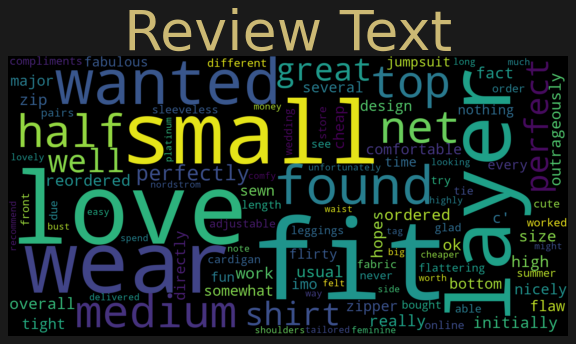

In [20]:
cloud(text = df['Review Text'].astype(str).values,
      title ='Review Text',
      stopwords = stopwords,
      size = (7,4))

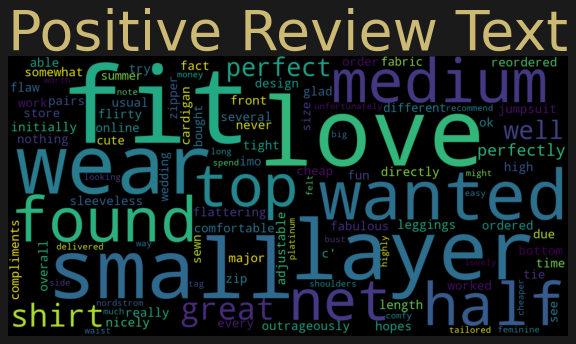

In [21]:
a = df[df['Rating']>=3]
cloud(text = a['Review Text'].astype(str).values,
      title ='Positive Review Text',
      stopwords = stopwords,
      size = (7,4))

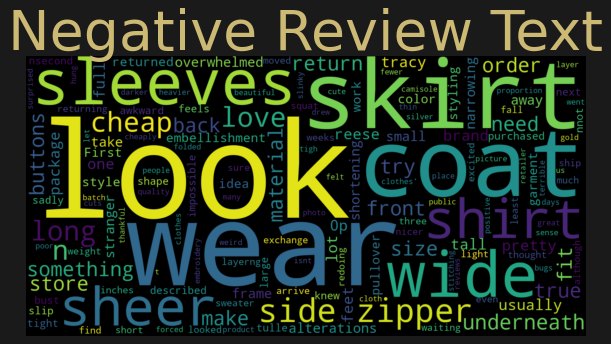

In [22]:
a = df[df['Rating']<3]
cloud(text = a['Review Text'].astype(str).values,
      title ='Negative Review Text',
      stopwords = stopwords,
      size = (7,4))

In [23]:
def preprocessing(data):
    txt = data.str.lower().str.cat(sep=' ') #1
    words = tokenizer.tokenize(txt) #2
    words = [w for w in words if not w in stopwords] #3
    #words = [ps.stem(w) for w in words] #4
    return words

def wordfreqviz(text, x):
    word_dist = nltk.FreqDist(text)
    top_N = x
    rslt = pd.DataFrame(word_dist.most_common(top_N),
                    columns=['Word', 'Frequency']).set_index('Word')
    matplotlib.style.use('ggplot')
    rslt.plot.bar(rot=0)

def wordfreq(text, x):
    word_dist = nltk.FreqDist(text)
    top_N = x
    rslt = pd.DataFrame(word_dist.most_common(top_N),
                    columns=['Word', 'Frequency']).set_index('Word')
    return rslt

# 6. ngrams<a id="ngrams"></a>
n-gram是意识基于统计自然语言模型的算法，其基本思想是将文本内容安装字节进行大小为N的窗口滚动计算，形成了长度为N的字节片段序列，每一个字节片段称为”gram“，如今广为应用的场景就是搜索引擎中的输入词汇提示。

In [24]:
from nltk.util import ngrams
from collections import Counter
def get_ngrams(text, n):
    n_grams = ngrams((text), n)
    return [ ' '.join(grams) for grams in n_grams]

def gramfreq(text,n,num):
    # Extracting bigrams
    result = get_ngrams(text,n)
    # Counting bigrams
    result_count = Counter(result)
    # Converting to the result to a data frame
    df = pd.DataFrame.from_dict(result_count, orient='index')
    df = df.rename(columns={'index':'words', 0:'frequency'}) # Renaming index column name
    return df.sort_values(["frequency"],ascending=[0])[:num]

def gram_table(data, gram, length):
    out = pd.DataFrame(index=None)
    for i in gram:
        table = pd.DataFrame(gramfreq(preprocessing(data),i,length).reset_index())
        table.columns = ["{}-Gram".format(i),"Occurrence"]
        out = pd.concat([out, table], axis=1)
    return out
print("Non-Recommended Items")

gram_table(data= df['Review Text'][df["Recommended IND"].astype(int) == 0], gram=[1,2,3,4,5], length=30)

Non-Recommended Items


,1-Gram,Occurrence,2-Gram,Occurrence,3-Gram,Occurrence,4-Gram,Occurrence,5-Gram,Occurrence
0,.,16853,' t,1751,. . .,608,' m 5 ',228,. ' m 5 ',140
1,",",8611,. .,1167,didn ' t,501,un ##fl ##atter ##ing,195,un ##fl ##atter ##ing .,90
2,',4960,' s,1137,. ' m,452,. ' m 5,158,didn ' t work .,63
3,t,1843,. ',1068,. ' s,406,. . . .,146,. . . . .,50
4,-,1806,' m,824,don ' t,294,. don ' t,108,' m 5 ' 4,39
5,top,1414,5 ',617,' m 5,254,", didn ' t",105,' s going back .,34
6,s,1402,didn ',501,m 5 ',230,. didn ' t,103,' m 5 ' 3,29
7,fit,1198,". ,",463,", ' s",197,didn ' t work,95,' m 5 ' 7,29
8,##s,1124,flat ##tering,402,un ##fl ##atter,197,##fl ##atter ##ing .,90,' m 5 ' 5,29
9,fabric,1117,", '",401,##fl ##atter ##ing,195,' t work .,78,", ' m 5 '",27


In [25]:
print("Recommended Items")
gram_table(data= df['Review Text'][df["Recommended IND"].astype(int) == 1], gram=[1,2,3,4,5], length=30)

Recommended Items


,1-Gram,Occurrence,2-Gram,Occurrence,3-Gram,Occurrence,4-Gram,Occurrence,5-Gram,Occurrence
0,.,71959,' s,5818,. . .,2372,' m 5 ',1229,. ' m 5 ',739
1,",",35063,' t,5675,. ' m,2289,. ' m 5,792,_ _ _ _ _,357
2,',22094,. ',5552,. ' s,2172,. . . .,591,. . . . .,237
3,!,11216,. .,4602,don ' t,1319,_ _ _ _,409,' m 5 ' 4,195
4,-,8381,' m,4431,' m 5,1311,. don ' t,360,- - - - -,156
5,s,7291,5 ',3286,m 5 ',1238,"5 ' 4 """,356,' m 5 ' 2,148
6,##s,7268,. love,3057,didn ' t,1097,"5 ' 3 """,285,' m 5 ' 5,146
7,love,6923,flat ##tering,2716,", ' s",876,"5 ' 5 """,281,( ' m 5 ',141
8,size,6781,", '",1791,. 5 ',868,"5 ' 2 """,266,' m 5 ' 3,140
9,t,6203,x ##s,1694,flat ##tering .,865,. didn ' t,257,' m 5 ' 6,126


In [26]:
from nltk.stem.porter import PorterStemmer
ps = PorterStemmer()
df['tokenized'] = df["Review Text"].astype(str).str.lower() # Turn into lower case text
df['tokenized'] = df.apply(lambda row: tokenizer.tokenize(row['tokenized']), axis=1) # Apply tokenize to each row
df['tokenized'] = df['tokenized'].apply(lambda x: [w for w in x if not w in stopwords]) # Remove stopwords from each row
df['tokenized'] = df['tokenized'].apply(lambda x: [ps.stem(w) for w in x]) # Apply stemming to each row
all_words = nltk.FreqDist(preprocessing(df['Review Text'])) # Calculate word occurrence from whole block of text

vocab_count = 200
word_features= list(all_words.keys())[:vocab_count] # 2000 most recurring unique words
print("Number of words columns (One Hot Encoding): {}".format(len(all_words)))

Number of words columns (One Hot Encoding): 9940


In [27]:
# Tuple
labtext= list(zip(df.tokenized, (df["Recommended IND"]))) 

# Function to create model features
# for each review, records which unique words out of the whole text body are present
def find_features(document):
    words = set(document)
    features = {}
    for w in word_features:
        features[w] = (w in words)

    return features
# Apply function to data
featuresets = [(find_features(text), LABEL) for (text, LABEL) in labtext]
len(featuresets)

# Train/Test
training_set = featuresets[:15000]
testing_set = featuresets[15000:]

# 7. 朴素贝叶斯<a id="bayes"></a>
* Independent Variable: 评论中的词汇选择
* Dependent Variable: 评论是否被推荐
监督学习通常被用来对未来进行预测。然而，一些简单的模型也可能被开辟出来，以提供一些洞察力。Naive Bayes是一个概率模型，它依赖于贝叶斯定理，通过观察一个词在不同类别中的出现情况来计算其类别的概率。由于这个模型同时考察了好的和坏的评论，它能够提取出最能使类别两极化的单格标记。使用这个模型，我有可能预测没有标签的评论的积极或消极情绪。


In [28]:
# Posterior = prior_occurrence * likelihood / evidence
classifier = nltk.NaiveBayesClassifier.train(training_set)

# Output
print("Classifier accuracy percent:",(nltk.classify.accuracy(classifier, testing_set))*100)
print(classifier.show_most_informative_features(40))

Classifier accuracy percent: 81.93908193908193
Most Informative Features
              compliment = True                1 : 0      =     11.7 : 1.0
                   cheap = True                0 : 1      =     10.7 : 1.0
                   flirt = True                1 : 0      =      6.2 : 1.0
                    idea = True                0 : 1      =      4.6 : 1.0
                   ##kee = True                0 : 1      =      4.6 : 1.0
                  pencil = True                1 : 0      =      4.2 : 1.0
                charcoal = True                1 : 0      =      4.0 : 1.0
                 perfect = True                1 : 0      =      3.7 : 1.0
                     fun = True                1 : 0      =      3.5 : 1.0
                    ##ec = True                1 : 0      =      3.3 : 1.0
                      wa = True                0 : 1      =      3.2 : 1.0
                     bum = True                0 : 1      =      3.0 : 1.0
                     net = 

# 8. 参考文献<a id="reference"></a>